# <font color = 'red'><b>Speech Emotion Recognition using CNN & LSTM</b></font>

## **DOWNLOADING ALL DATASETS**

In [ ]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

!unzip speech-emotion-recognition-en.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  
  inflating: Crema/1088_TSI_DIS_XX.wav  
  infl

## **Importing Required Libraries**

In [ ]:
# Importing System Libraries
import os, sys

# Importing Data Manipulation Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Machine Learning Libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Importing Audio Processing Libraries
import librosa
import librosa.display
import soundfile
from IPython.display import Audio, display

# Importing Deep Learning Libraries
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Ignore Warnings
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## **Loading the Dataset**

In [ ]:
# Dataset Paths
tess = "/content/Tess/"

## **Loading the TESS dataset**

A dataset for training emotion (7 cardinal emotions) classification in audio.

The dataset contains the speech of young and old people, in the folders starting with O and Y repectfully.

In [ ]:
tess_dir_list = os.listdir(tess)
file_emotion = []
file_path = []

for dir in tess_dir_list:
    directories = os.listdir(tess + dir)
    for file in directories:
        file_path.append(tess + dir + '/' + file)
        part = file.split('.')[0]
        part = part.split('_')[2]

        if part == 'ps':
            file_emotion.append('surprise')
        elif part == 'happy':
            file_emotion.append('happy')
        elif part == 'sad':
            file_emotion.append('sad')
        elif part == 'fear':
            file_emotion.append('fear')
        elif part == 'angry':
            file_emotion.append('angry')
        elif part == 'disgust':
            file_emotion.append('disgust')
        elif part == 'neutral':
            file_emotion.append('neutral')
        else:
            file_emotion.append('unknown')

tess_df = pd.DataFrame({'Emotions':file_emotion, 'Path': file_path})
tess_df.head()

,Emotions,Path
0,happy,/content/Tess/OAF_happy/OAF_keep_happy.wav
1,happy,/content/Tess/OAF_happy/OAF_rain_happy.wav
2,happy,/content/Tess/OAF_happy/OAF_lean_happy.wav
3,happy,/content/Tess/OAF_happy/OAF_bar_happy.wav
4,happy,/content/Tess/OAF_happy/OAF_phone_happy.wav


In [ ]:
tess_df.Emotions.value_counts()

,count
Emotions,
happy,400
fear,400
sad,400
neutral,400
disgust,400
angry,400
surprise,400


---

# **Visualization:**

In [ ]:
sns.set_style(style='whitegrid')

<ipython-input-7-53343cf69ba9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'Emotions', data = tess_df, palette = 'Set1', legend = False)


Text(0.5, 1.0, 'Count of Emotions in TESS df')

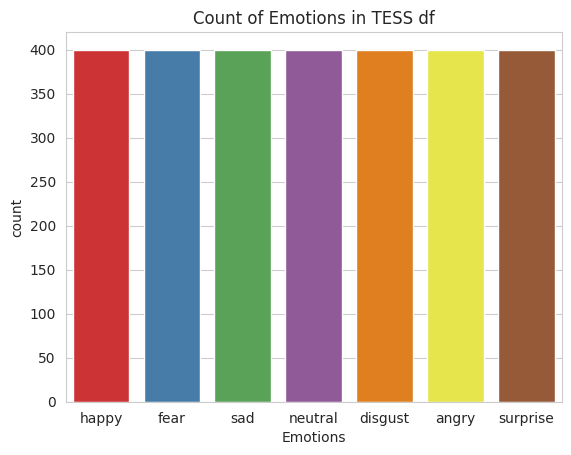

In [ ]:
sns.countplot(x = 'Emotions', data = tess_df, palette = 'Set1', legend = False)
plt.title('Count of Emotions in TESS df')

In [ ]:
# df = pd.concat([crema_df, ravdess_df, savee_df, tess_df], axis = 0)
# df.reset_index(drop = True, inplace = True)
# df.head()

In [ ]:
# Function to plot waveform
def plot_waveform(file_path, emotion, duration=2.5, offset=0.6):
    """
    Plot the waveform of an audio file.

    Parameters:
    - file_path (str): Path to the audio file.
    - emotion (str): Emotion label for the audio file.
    - duration (float): Duration to load from the audio file (in seconds).
    - offset (float): Offset from the start of the file to begin loading (in seconds).
    """
    # Load the audio file
    y, sr = librosa.load(file_path, duration=duration, offset=offset)

    # Plot waveform
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr, alpha=0.7)
    plt.title(f'Waveform - Emotion: {emotion}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Function to plot spectrogram
def plot_spectrogram(file_path, emotion, duration=2.5, offset=0.6):
    """
    Plot the spectrogram of an audio file.

    Parameters:
    - file_path (str): Path to the audio file.
    - emotion (str): Emotion label for the audio file.
    - duration (float): Duration to load from the audio file (in seconds).
    - offset (float): Offset from the start of the file to begin loading (in seconds).
    """

    # Load the audio file
    y, sr = librosa.load(file_path, duration=duration, offset=offset)

    # Compute the Short-Time Fourier Transform (STFT)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Plot spectrogram
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.title(f'Spectrogram - Emotion: {emotion}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [ ]:
tess_df.Emotions.value_counts()

,count
Emotions,
happy,400
fear,400
sad,400
neutral,400
disgust,400
angry,400
surprise,400


Visualizing /content/Tess/YAF_angry/YAF_hurl_angry.wav - Emotion: angry


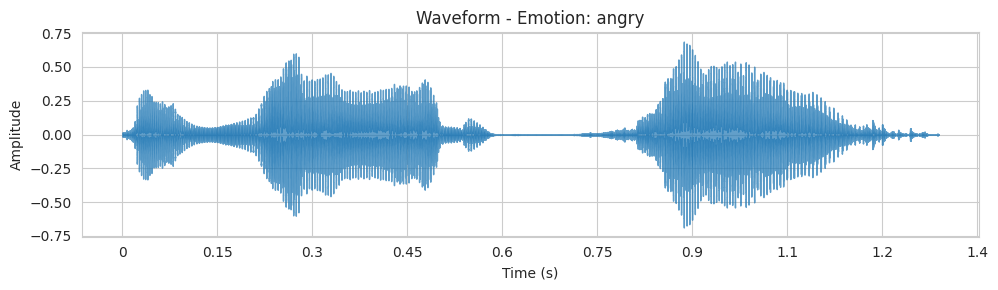

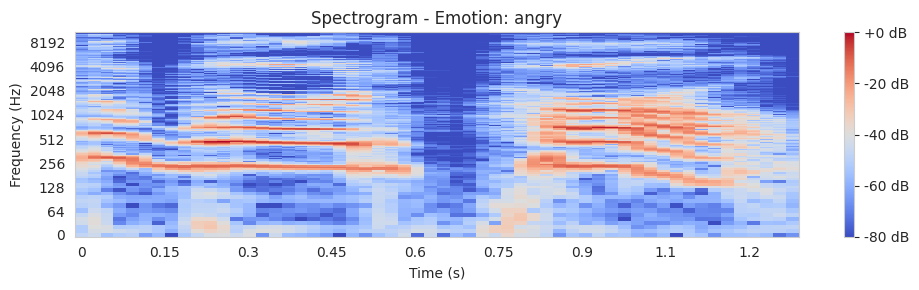

Visualizing /content/Tess/YAF_disgust/YAF_lid_disgust.wav - Emotion: disgust


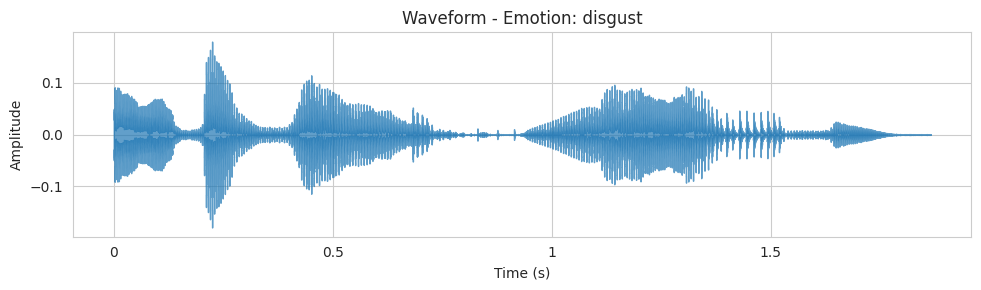

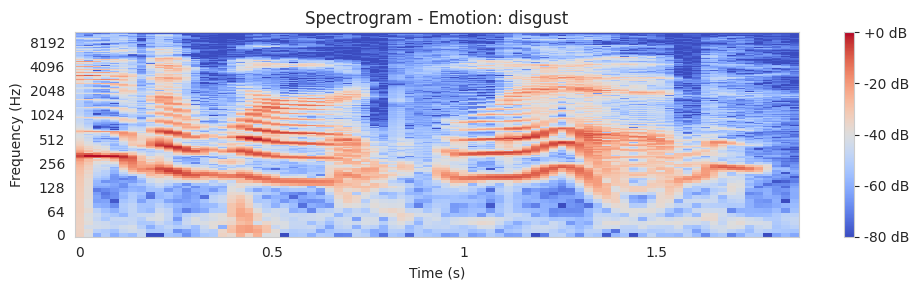

Visualizing /content/Tess/YAF_fear/YAF_shout_fear.wav - Emotion: fear


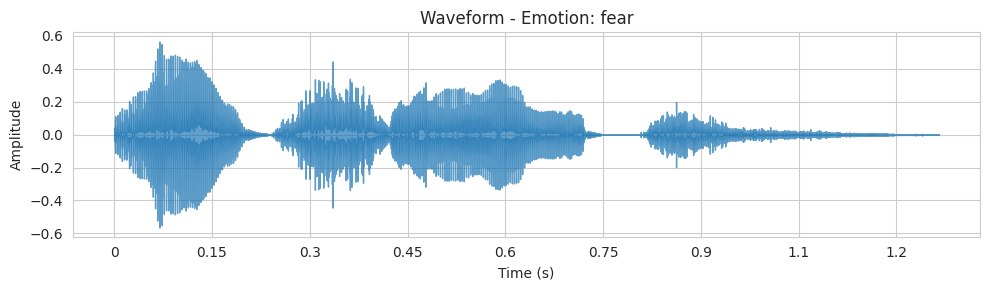

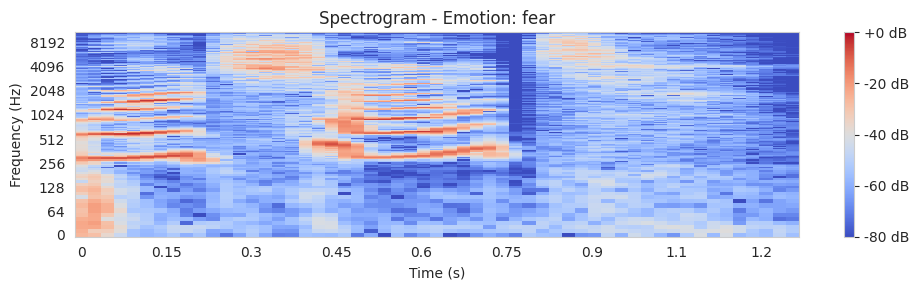

Visualizing /content/Tess/YAF_happy/YAF_fat_happy.wav - Emotion: happy


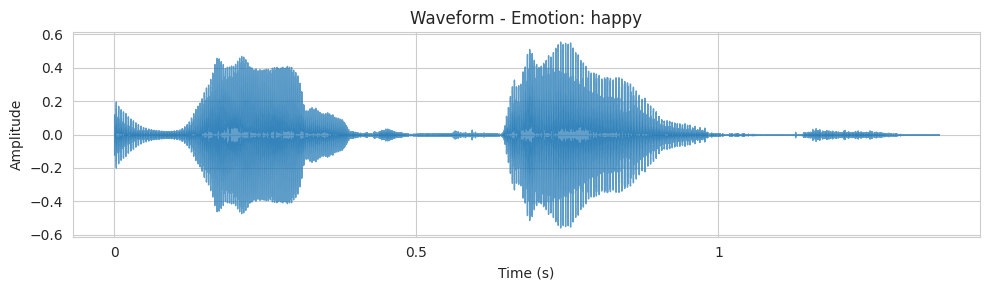

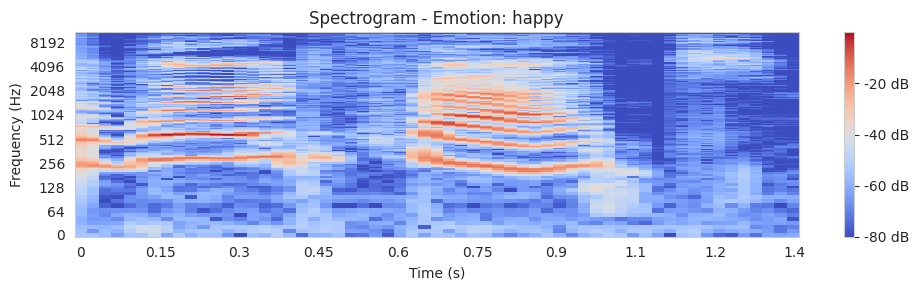

Visualizing /content/Tess/OAF_neutral/OAF_shall_neutral.wav - Emotion: neutral


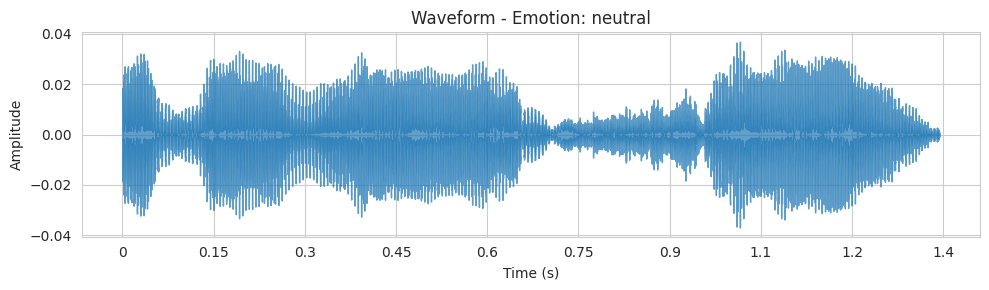

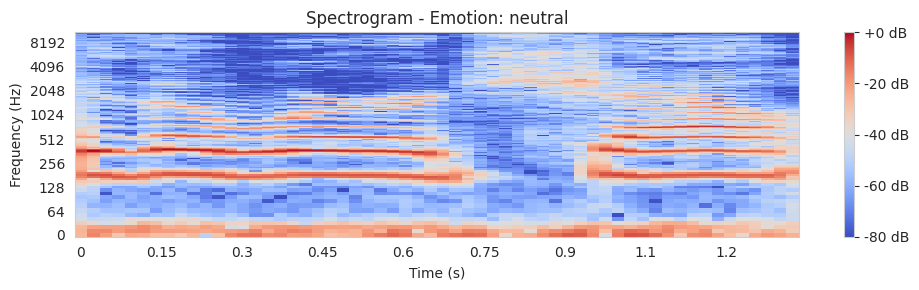

Visualizing /content/Tess/YAF_sad/YAF_rot_sad.wav - Emotion: sad


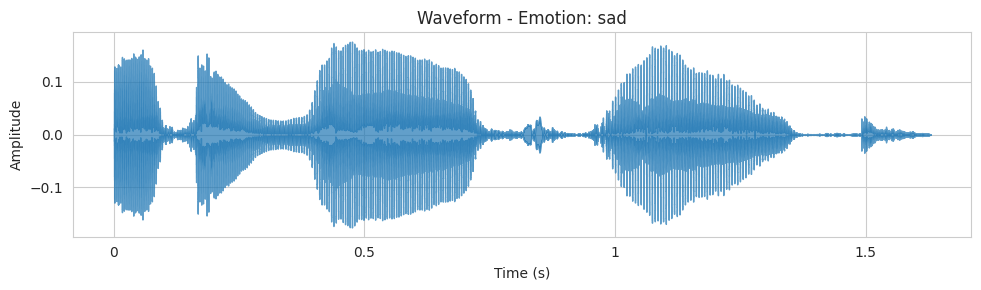

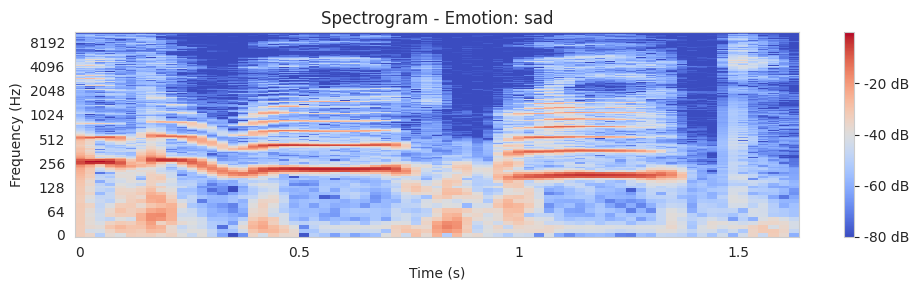

In [ ]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

# Creating a dataframe which will hold distinct emotion from data
each_emotion_df = pd.DataFrame(columns = ['Emotions', 'Path'])

# Appending each emotion in the each_emotion_df
for emotion in emotions:
    row = tess_df[tess_df['Emotions'] == emotion].sample(1)
    each_emotion_df = pd.concat([each_emotion_df, row], axis = 0)

# Plotting Waveplot and Spectogram for each emotion
for index, row in each_emotion_df.iterrows():
    file_path = row['Path']
    emotion = row['Emotions']
    print(f"Visualizing {file_path} - Emotion: {emotion}")
    plot_waveform(file_path, emotion)
    plot_spectrogram(file_path, emotion)
    display(Audio(file_path))

# **Feature Extraction:**

In [ ]:
# tess_df

In [ ]:
# def extract_features(file_path):
#     y, sr = librosa.load(file_path)
#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#     return mfccs.mean(axis=1)

# tess_df['features'] = tess_df['Path'].apply(extract_features) # Extracting features from audio files


In [ ]:
# tess_df.features[0].shape

In [ ]:
# Function to extract features from audio files
def extract_features(file_name):
    """
    Extracts audio features from a file.

    Parameters:
    - file_name (str): Path to the audio file.

    Returns:
    - features (np.ndarray): Extracted feature vector.
    """
    y, sr = librosa.load(file_name, duration=2.5, offset=0.6)

    # Extract various features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    # Aggregate features
    features = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(mel, axis=1),
        np.mean(contrast, axis=1),
        np.mean(zcr, axis=1)
    ])

    return features

def extract_features_df(data):
    """
    Extracts features from a DataFrame of audio files.

    Parameters:
    - df (pd.DataFrame): DataFrame containing audio file paths.

    Returns:
    - features_df (pd.DataFrame): DataFrame with extracted features.
    """

    # Initialize lists to store features and labels
    emotion_labels = []
    features_list = []

    # Iterate through the DataFrame and extract features
    for index, row in data.iterrows():
        file_path = row['Path']
        emotion = row['Emotions']

        # Extract features and append to lists
        features = extract_features(file_path)
        features_list.append(features)
        emotion_labels.append(emotion)

    # Convert lists to a DataFrame
    features_df = pd.DataFrame(features_list)
    features_df['emotion'] = emotion_labels

    print("Feature extraction complete.")
    return features_df

features_df = extract_features_df(tess_df)
print("Features shape:", features_df.shape)

Feature extraction complete.
Features shape: (2800, 189)


In [ ]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,emotion
0,-508.875854,82.663803,25.988668,2.479900,6.955186,0.939620,-0.360106,-4.516583,-19.585882,-3.241397,...,6.257636e-07,23.940555,19.964211,22.683940,18.462241,19.519362,18.340529,48.120860,0.053505,happy
1,-467.281677,122.170593,23.766117,-17.581739,2.369207,-2.309299,-2.646915,-1.052038,-22.053844,-13.687083,...,9.228860e-07,25.257731,24.560967,25.305973,19.768515,19.879680,17.628202,47.290190,0.036989,happy
2,-468.345367,107.398392,32.941677,-0.575371,-5.747000,2.788520,-2.554523,-2.540437,-24.473154,-15.807933,...,1.032370e-06,24.361426,24.484648,27.008431,21.532900,21.468302,18.661137,47.037552,0.032279,happy
3,-470.679077,122.722488,21.269403,-31.483896,-1.214130,10.635306,-1.373333,-4.557412,-13.153536,1.649074,...,1.015455e-06,24.868058,22.886602,21.524497,19.248140,21.323266,17.661344,47.188032,0.043865,happy
4,-476.281494,102.199684,32.236416,-21.052143,1.036629,-0.566555,-3.703326,-1.703693,-18.353600,-3.925766,...,2.769415e-06,24.792702,21.307735,22.695030,20.537800,19.506292,18.552304,46.506599,0.121102,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,-360.653503,66.308708,-10.777113,-11.637038,-29.205053,7.298297,1.117775,-13.096662,-11.172334,1.206840,...,9.263787e-06,18.120352,19.331433,19.892962,18.510811,18.731041,19.531909,48.581759,0.134218,surprise
2796,-374.004425,70.710915,-18.806719,-4.506109,-29.920759,10.068765,4.595311,-11.732683,-9.738617,2.184784,...,8.835325e-06,17.009586,17.543669,20.860584,18.579987,18.997659,19.942917,48.086024,0.128703,surprise
2797,-399.799835,53.539272,-0.964426,24.903982,-13.067920,-6.455890,-12.705200,-19.390133,-16.320246,-3.136582,...,1.141976e-05,16.140213,21.403717,24.720123,18.465624,20.919112,20.149343,48.390995,0.103783,surprise
2798,-337.791565,80.265839,-25.285683,0.674130,-17.662352,1.842775,-11.967171,-25.929392,-2.254090,4.272309,...,3.708789e-05,17.760869,18.882441,20.161777,17.501080,20.964933,23.357753,48.576416,0.131605,surprise


In [ ]:
# features_df.describe()

In [ ]:
# Encoding the target column
lb = LabelEncoder()
features_df['emotion'] = lb.fit_transform(features_df['emotion'])

# Display the mapping of labels to integers
label_mapping = dict(zip(lb.classes_, lb.transform(lb.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Splitting the dataset
X = features_df.drop('emotion', axis=1)
y = features_df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [ ]:
X_train.shape, X_test.shape

((2240, 188), (560, 188))

In [ ]:
# Scaling the inputs
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [ ]:
# X_train

In [ ]:
# One-Hot Encoding the target column
y_train_encoded = to_categorical(y_train, num_classes = y_train.nunique())
y_test_encoded = to_categorical(y_test, num_classes = y_train.nunique())

# **Model Building**

## **Building Model Using CNN & LSTM**

In [ ]:
X_train.shape, X_test.shape

((2240, 188), (560, 188))

In [ ]:
# Reshape the input data for CNN
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN-LSTM model
model = Sequential()

# Input layer
model.add(Input(shape=(X_train_reshaped.shape[1], 1)))

# CNN layers
model.add(Conv1D(64, kernel_size=3, activation='relu')) # relu(x) = max(0, x)
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(128))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 186, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 93, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 93, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 91, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 45, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 43, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 21, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 471,431 (1.80 MB)

 Trainable params: 470,535 (1.79 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Early Stopping

# earlystopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [ ]:
# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=50, validation_data = (X_test_reshaped, y_test_encoded))

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy: 0.3165 - loss: 1.6204 - val_accuracy: 0.1196 - val_loss: 3.4069
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.7924 - loss: 0.5985 - val_accuracy: 0.1125 - val_loss: 5.0294
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - accuracy: 0.8429 - loss: 0.4259 - val_accuracy: 0.1250 - val_loss: 4.3416
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.9430 - loss: 0.1764 - val_accuracy: 0.1357 - val_loss: 5.3804
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.9480 - loss: 0.1896 - val_accuracy: 0.4607 - val_loss: 2.3589
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.9776 - loss: 0.0778 - val_accuracy: 0.6464 - val_loss: 1.4815
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.9741 - loss: 0.0879 - val_accuracy: 0.8732 - val_loss: 0.4833
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.9803 - loss: 0.0647 - val_accu

(0.0, 2.5)

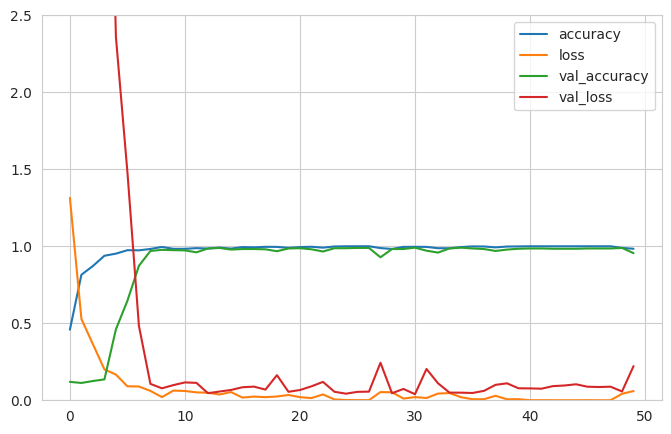

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2.5)

In [ ]:
y_prob = model.predict(X_test_reshaped)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test_encoded, axis = 1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [ ]:
# Accuracy
accuracy_score(y_true, y_pred)

0.9553571428571429

In [ ]:
# Confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)
confusion_mat

array([[75,  2,  5,  0,  0,  0,  7],
       [ 0, 89,  0,  1,  0,  0,  0],
       [ 0,  0, 78,  0,  0,  0,  0],
       [ 0,  0,  2, 82,  0,  0,  1],
       [ 0,  0,  0,  0, 81,  0,  0],
       [ 0,  1,  0,  0,  0, 61,  0],
       [ 0,  1,  0,  5,  0,  0, 69]])

In [ ]:
label_mapping

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
# Print the classification report
target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names = target_names))

Classification Report:
              precision    recall  f1-score   support

       angry       1.00      0.84      0.91        89
     disgust       0.96      0.99      0.97        90
        fear       0.92      1.00      0.96        78
       happy       0.93      0.96      0.95        85
     neutral       1.00      1.00      1.00        81
         sad       1.00      0.98      0.99        62
    surprise       0.90      0.92      0.91        75

    accuracy                           0.96       560
   macro avg       0.96      0.96      0.96       560
weighted avg       0.96      0.96      0.95       560



Text(70.72222222222221, 0.5, 'True')

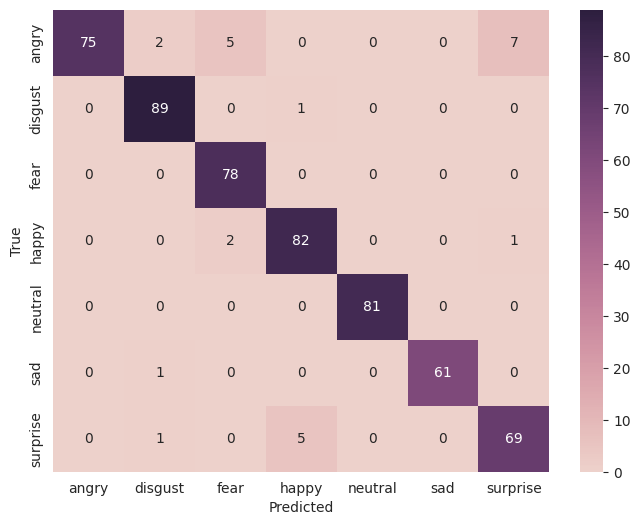

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
# Saving the model
model.save('model.keras')

---

## **<font color = 'red'>Team Profiles</font>**

Tap to view profile

<a href="https://www.linkedin.com/in/programmer70" target="_blank" style="text-decoration:none;">
    <button style="padding:10px 15px; background-color:pink; color:white; border:none; border-radius:5px;">
        Sahil Khan
    </button>
</a>
<a href="https://www.linkedin.com/in/manasvi-kulshrestha-757971227" target="_blank" style="text-decoration:none;">
    <button style="padding:10px 15px; background-color:pink; color:white; border:none; border-radius:5px;">
        Manasvi Kulshrestha
    </button>
</a>
<a href="https://www.linkedin.com/in/divyanshsingh3400" target="_blank" style="text-decoration:none;">
    <button style="padding:10px 15px; background-color:pink; color:white; border:none; border-radius:5px;">
        Divyansh Singh
    </button>
</a>
<a href="https://www.linkedin.com/in/aman-datta-784584215" target="_blank" style="text-decoration:none;">
    <button style="padding:10px 15px; background-color:pink; color:white; border:none; border-radius:5px;">
        Aman Datta
    </button>
</a>
<a href="https://www.linkedin.com/in/ashutosh-dewangan-1228b1228" target="_blank" style="text-decoration:none;">
    <button style="padding:10px 15px; background-color:pink; color:white; border:none; border-radius:5px;">
        Ashutosh Dewangan
    </button>
</a>


